# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10

# helper function to compute accuracy given predictions and labels
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
# helper function to generate a convolution of size nxm with a stride of nxm for input data and its weights
def conv2d(x, w, n, m):
  return tf.nn.conv2d(x, w, strides=[1, n, m, 1], padding='SAME')

# helper function to generate a maxpool rendition of the input data
def maxpool(x, n, m):
  return tf.nn.max_pool(x, ksize=[1, n, m, 1], strides=[1, n, m, 1], padding='SAME')

#helper function to build a weight variable of given sha  pe
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
#helper function to build 
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def create_logits (X, weights, biases, dropout=False):
    #initialize relu_logits as the input dataset
    nlayer = len(weights.keys())
    cur_logits = X
    for layer in range(nlayer):
        logits = tf.matmul(cur_logits, weights[layer]) + biases[layer]
        # Transform logits computed from layer 1 using relu function to compute logits for layer2
        if layer < nlayer-1:
            cur_logits = tf.nn.relu(logits)
        # Dropout on hidden layers only
            if dropout:
                cur_logits = tf.nn.dropout(cur_logits, 0.75)

    # Apply activation function to transform logits from the last layer to generate predictions for training samples
    y_pred = tf.nn.softmax(logits)
    return y_pred, logits

# helper function to flatten 2d images to 1d tensor
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


#Create a single hidden layer neural network using RELU and 1024 nodes
def n_layer_nn (X_train, y_train, X_valid, y_valid, X_test, y_test, image, num_classes, 
  batch_size=128, num_nodes=[1024], num_samples=0, num_steps = 1001, print_steps=100, dropout=False):
  beta = .01
  init_learning_rate = 0.1
  if num_samples ==0:
      num_samples = y_train.shape[0]

  graph = tf.Graph()
  #build nodes array and append it with the number of classes which is final number of nodes
  nodes_list = num_nodes
  nodes_list.append(num_classes)

  with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_X_train = tf.placeholder(tf.float32, shape=(batch_size, image[0] * image[1]))
      tf_y_train = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

      tf_X_valid = tf.constant(X_valid)
      tf_X_test  = tf.constant(X_test)
      # save weights and biases in a dictionary for each layer
      weights={}
      biases ={}
      # first dimesion of the weights will be the number of features in the training dataset which is the image size
      dim1 = image[0] * image[1]
      # build weights and biases for each layer
      for i, nodes in enumerate(nodes_list):
          weights[i] = tf.Variable(tf.truncated_normal([dim1, nodes]))
          biases[i]  = tf.Variable(tf.zeros([nodes]))
          w_l2_loss = tf.nn.l2_loss(weights[i])
          regularizers = regularizers + w_l2_loss if  i else w_l2_loss
          # Subsequent layer first dimension would the number of nodes in the previous layer
          dim1 = nodes

      y_train_pred, logits = create_logits (tf_X_train, weights, biases, dropout)

      # compute the loss comparing logits from layer 2 and the training labels
      cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_y_train, logits=logits))
      # Loss function with L2 Regularization with beta
      loss = tf.reduce_mean(cross_entropy + beta * regularizers)

      # Optimize using Gradient Descent
      global_step = tf.Variable(0)  # count the number of steps taken.
      learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, decay_steps=100000, decay_rate=0.96, staircase=True)
      optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
      
      # Transform validation samples using the same transformation used above for training samples
      y_valid_pred, _ = create_logits (tf_X_valid, weights, biases)
      
      # Transform test samples using the same transformation used above for training samples
      y_test_pred, _ = create_logits (tf_X_test, weights, biases)


  with tf.Session(graph=graph) as session:
      # This is a one-time operation which ensures the parameters get initialized as
      # we described in the graph: random weights for the matrix, zeros for the
      # biases. 
      tf.global_variables_initializer().run()
      print ('\nstep#       Loss     Training Accuracy Validation Accuracy')
      for step in range(num_steps):
          offset = (step * batch_size) % (num_samples - batch_size)
          # Generate a minibatch from the training dataset for Stocastic Gradient Descent
          batch_X = X_train[offset:(offset + batch_size), :]
          batch_y = y_train[offset:(offset + batch_size), :]
          # Prepare a dictionary telling the session where to feed the minibatch.
          # The key of the dictionary is the placeholder node of the graph to be fed,
          # and the value is the numpy array to feed to it.
          feed_dict = {tf_X_train : batch_X, tf_y_train : batch_y}
          _, l, y_pred = session.run([optimizer, loss, y_train_pred], feed_dict=feed_dict)

          # Run the computations. We tell .run() that we want to run the optimizer,
          # and get the loss value and the training predictions returned as numpy
          # arrays.
          if (step % print_steps == 0):
              print('{0:5d} {1:10.2f} {2:15.2f} {3:15.2f}'.format(step, l, accuracy(y_pred, batch_y), 
                                                            accuracy(y_valid_pred.eval(), y_valid)))
              # Calling .eval() on valid_prediction is basically like calling run(), but
              # just to get that one numpy array. Note that it recomputes all its graph
              # dependencies.
      print('Test accuracy: {:.1f}'.format(accuracy(y_test_pred.eval(), y_test))) 
batch_size = 128
num_nodes= [4096]
image = [image_size,image_size]
nclass = 10
num_steps = 2501
print_steps = 500
dropout = False
num_samples=0 # try with full dataset first
n_layer_nn (train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels, image, 
  nclass, batch_size, num_nodes, num_samples, num_steps, print_steps, dropout)


Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)

step#       Loss     Training Accuracy Validation Accuracy
    0   13228.33            6.25           36.94
  500    4624.13           83.59           82.99
 1000    1695.38           82.81           83.41
 1500     621.40           82.81           83.09
 2000     228.41           85.16           85.43
 2500      84.29           85.16           88.46
Test accuracy: 93.5


In [19]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import scipy.io as sio
import matplotlib.pyplot as plt

def reformat(X, Y, image_size, num_channels, num_labels):
	x = np.zeros((X.shape[3],image_size,image_size,num_channels),dtype=np.float32)
	for i in range(X.shape[3]):
		x[i,] = X[:,:,:,i]
	y = (np.arange(num_labels) == Y[:,None]).astype(np.float32)
	return x, y

def reformat_mnist(dataset, labels, image_size, num_channels, num_labels):
	dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
	labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
	return dataset, labels

mnist_data = True
if mnist_data:
	pickle_file = 'notMNIST.pickle'

	with open(pickle_file, 'rb') as f:
		save = pickle.load(f)
		train_dataset = save['train_dataset']
		train_labels = save['train_labels']
		valid_dataset = save['valid_dataset']
		valid_labels = save['valid_labels']
		test_dataset = save['test_dataset']
		test_labels = save['test_labels']
		del save  # hint to help gc free up memory
		print('MNIST Training set', train_dataset.shape, train_labels.shape)
		print('MNIST Validation set', valid_dataset.shape, valid_labels.shape)
		print('MNIST Test set', test_dataset.shape, test_labels.shape)

	image_size   = train_dataset.shape[1] #image size
	num_labels   = 10 #TODO: number of different label types
	num_channels = 1 #set as 1:grayscale, or 3: color (RGB)

	X_train, y_train = reformat_mnist(train_dataset, train_labels, image_size, num_channels, num_labels)
	X_valid, y_valid = reformat_mnist(valid_dataset, valid_labels, image_size, num_channels, num_labels)
	X_test,  y_test  = reformat_mnist(test_dataset,  test_labels,  image_size, num_channels, num_labels)

	print('MNIST Training set',   X_train.shape, y_train.shape)
	print('MNIST Validation set', X_valid.shape, y_valid.shape)
	print('MNIST Testing set',    X_test.shape,  y_test.shape)
else:
	train_data = sio.loadmat('train_32x32.mat')
	test_data  = sio.loadmat('test_32x32.mat')

	X_data = train_data['X']
	y_data = train_data['y'].reshape(-1)
	X_test = test_data['X']
	y_test = test_data['y'].reshape(-1)

	print('Real Data     X Shape,       Y_shape')
	print('Training', X_data.shape, y_data.shape)
	print('Testing ', X_test.shape, y_test.shape)

	image_size   = X_data.shape[0] #TODO: image size
	num_labels   = 10 #TODO: number of different label types
	num_channels = X_data.shape[2] #TODO: set as 1:grayscale, or 3: color (RGB)

	# reshape data for input to CNN model
	X_data, y_data = reformat(X_data, y_data, image_size, num_channels, num_labels)
	X_test, y_test = reformat(X_test, y_test, image_size, num_channels, num_labels)

	# normalize X values between 0 to 1
	X_data = X_data/255
	X_test = X_test/255

	#split X_data, y_data into two chunks of training and validation data
	ntrain = round(.8*X_data.shape[0])
	X_train = X_data[:ntrain]
	y_train = y_data[:ntrain]
	X_valid = X_data[ntrain:]
	y_valid = y_data[ntrain:]

	print('Training  ', X_train.shape, y_train.shape)
	print('Validation', X_valid.shape, y_valid.shape)
	print('Testing   ', X_test.shape,  y_test.shape)

def accuracy(predictions, labels):
	return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

batch_size = 128
patch_size = 5
depth      = 16
num_hidden = 128
maxpool    = True
dropout    = True
# build a convolutional model for the given input data, weights and biases
def model(X, weights, biases, maxpool=False, dropout=False):
	nlayer = len(weights.keys())
	hidden = X
	for layer in range(nlayer-2):
		print("shape before conv layer:", hidden.get_shape(), weights[layer].get_shape())
		hidden = tf.nn.relu(conv2d(hidden, weights[layer]) + biases[layer])
		print("shape after conv layer:", hidden.get_shape())
		if maxpool:
			hidden = max_pool_2x2(hidden)
			print("shape after maxpool layer:", hidden.get_shape())
		if (dropout):
			hidden = tf.nn.dropout(hidden, .8)

	shape  = hidden.get_shape().as_list()
	hidden = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
	print("shape for fully connected relu layer:", hidden.get_shape(), weights[nlayer-2].get_shape())
	hidden = tf.nn.relu(tf.matmul(hidden, weights[nlayer-2]) + biases[nlayer-2])
	print("shape for fully connected output layer:", hidden.get_shape(), weights[nlayer-1].get_shape())
	logits = tf.matmul(hidden, weights[nlayer-1]) + biases[nlayer-1]
	return logits

graph = tf.Graph()

with graph.as_default():
	# Input data.
	tf_X_train = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
	tf_y_train = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
	tf_X_valid = tf.constant(X_valid)
	tf_X_test  = tf.constant(X_test)

	# Variables.
	weights={}
	biases ={}
	# first dimesion of the weights will be the number of features in the training dataset which is the image size
	# build weights and biases for each layer

	weights[0] = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
	biases[0]  = tf.Variable(tf.zeros([depth]))
	weights[1] = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
	biases[1]  = tf.Variable(tf.constant(1.0, shape=[depth]))
	dim1       = depth*16*4
	if maxpool:
		dim1 = dim1//16
	weights[2] = tf.Variable(tf.truncated_normal([dim1, num_hidden], stddev=0.1))
	biases[2]  = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
	weights[3] = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
	biases[3]  = tf.Variable(tf.constant(1.0, shape=[num_labels]))

	# Build CNN model using specified weights with option to maxpool and dropout
	logits = model(tf_X_train, weights, biases, maxpool, dropout)

	# Training computation.
	loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_y_train, logits=logits))
	# Loss function with L2 Regularization with beta
	l2_loss = True
	if l2_loss:
		beta = .01
		nlayer = len(weights.keys())
		for layer in range(nlayer):
			w_l2_loss = tf.nn.l2_loss(weights[layer])
			regularizers = regularizers + w_l2_loss if  layer else w_l2_loss
		loss = tf.reduce_mean(loss + beta * regularizers)

	# Build optimizer with exponential decay
	#optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
	init_learning_rate = 0.05
	global_step = tf.Variable(0)  # count the number of steps taken.
	learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, decay_steps=100000, decay_rate=0.96, staircase=True)
	optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

	# Predictions for the training, validation, and test data.
	train_prediction = tf.nn.softmax(logits)
	valid_prediction = tf.nn.softmax(model(tf_X_valid, weights, biases, maxpool, dropout))
	test_prediction = tf.nn.softmax(model(tf_X_test, weights, biases, maxpool, dropout))

num_steps = 5001
print_steps = 500
with tf.Session(graph=graph) as session:
	tf.global_variables_initializer().run()
	print('Initialized')
	print ('\nstep#       Loss     Training Accuracy Validation Accuracy')
	for step in range(num_steps):
		offset = (step * batch_size) % (y_train.shape[0] - batch_size)
		batch_data = X_train[offset:(offset + batch_size), :, :, :]
		batch_labels = y_train[offset:(offset + batch_size), :]
		feed_dict = {tf_X_train : batch_data, tf_y_train : batch_labels}
		_, l, predictions = session.run(
		[optimizer, loss, train_prediction], feed_dict=feed_dict)
		if (step % print_steps == 0):
			print('{0:5d} {1:10.2f} {2:15.2f} {3:15.2f}'.format(step, l, accuracy(predictions, batch_labels),
																accuracy(valid_prediction.eval(), y_valid)))
	print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), y_test))

MNIST Training set (200000, 28, 28) (200000,)
MNIST Validation set (10000, 28, 28) (10000,)
MNIST Test set (10000, 28, 28) (10000,)
MNIST Training set (200000, 28, 28, 1) (200000, 10)
MNIST Validation set (10000, 28, 28, 1) (10000, 10)
MNIST Testing set (10000, 28, 28, 1) (10000, 10)
shape before conv layer: (128, 28, 28, 1) (5, 5, 1, 16)
shape after conv layer: (128, 14, 14, 16)
shape after maxpool layer: (128, 7, 7, 16)
shape before conv layer: (128, 7, 7, 16) (5, 5, 16, 16)
shape after conv layer: (128, 4, 4, 16)
shape after maxpool layer: (128, 2, 2, 16)
shape for fully connected relu layer: (128, 64) (64, 128)
shape for fully connected output layer: (128, 128) (128, 10)
shape before conv layer: (10000, 28, 28, 1) (5, 5, 1, 16)
shape after conv layer: (10000, 14, 14, 16)
shape after maxpool layer: (10000, 7, 7, 16)
shape before conv layer: (10000, 7, 7, 16) (5, 5, 16, 16)
shape after conv layer: (10000, 4, 4, 16)
shape after maxpool layer: (10000, 2, 2, 16)
shape for fully connecte

In [9]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import scipy.io as sio
import matplotlib.pyplot as plt

def reformat(X, Y, image_size, num_channels, num_labels):
	x = np.zeros((X.shape[3],image_size,image_size,num_channels),dtype=np.float32)
	for i in range(X.shape[3]):
		x[i,] = X[:,:,:,i]
	y = (np.arange(num_labels) == Y[:,None]).astype(np.float32)
	return x, y

def load_digits_dataset(mnist_data=True):
	if mnist_data:
		K.set_image_dim_ordering('th')
		# load data
		(X_train, y_train), (X_test, y_test) = mnist.load_data()

		print('Data Set      X Shape,       Y_shape')
		print('Training', X_train.shape, y_train.shape)
		print('Testing ', X_test.shape, y_test.shape)

		# reshape to be [samples][pixels][width][height]
		X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
		X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

		print('Training', X_train.shape, y_train.shape)
		print('Testing ', X_test.shape, y_test.shape)

		# normalize inputs from 0-255 to 0-1
		X_train = X_train / 255
		X_test = X_test / 255
		# one hot encode outputs
		y_train = np_utils.to_categorical(y_train)
		y_test = np_utils.to_categorical(y_test)
		num_classes = y_test.shape[1]
		print('\nFinal Data      X Shape,       Y_shape')
		print('Training', X_train.shape, y_train.shape)
		print('Testing ', X_test.shape, y_test.shape)
		input_shape = (1, 28, 28)
		print ('input shape', input_shape)
	else:
		K.set_image_dim_ordering('tf')
		train_data = sio.loadmat('train_32x32.mat')
		test_data  = sio.loadmat('test_32x32.mat')

		X_train = train_data['X']
		y_train = train_data['y'].reshape(-1)
		X_test = test_data['X']
		y_test = test_data['y'].reshape(-1)

		print('\n\nReal Set      X Shape,       Y_shape')
		print('Training', X_train.shape, y_train.shape)
		print('Testing ', X_test.shape, y_test.shape)

		image_size   = X_train.shape[0] #image size
		num_channels = X_train.shape[2] #set as 1:grayscale, or 3: color (RGB)
		num_classes = 10 # number of types of digits (0-9)

		# reshape to be [samples][pixels][width][height]
		# reshape data for input to CNN model

		X_train, y_train = reformat(X_train, y_train, image_size, num_channels, num_classes)
		X_test, y_test   = reformat(X_test, y_test, image_size, num_channels, num_classes)
		# normalize X values between 0 to 1
		X_train = X_train / 255
		X_test = X_test / 255
		print('\nFinal Data      X Shape,       Y_shape')
		print('Training', X_train.shape, y_train.shape)
		print('Testing ', X_test.shape, y_test.shape)
		input_shape = (image_size, image_size, num_channels)
		print ('input shape', input_shape)
	return X_train, y_train, X_test, y_test, input_shape, num_classes
#========================================================================================
def larger_model(input_shape, num_classes):
	# create model
	model = Sequential()
	model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=input_shape, activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Convolution2D(16, 3, 3, activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(64, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility

In [6]:
seed = 7
np.random.seed(seed)

X_train, y_train, X_test, y_test, input_shape, num_classes = load_digits_dataset (True)
# build the model
model = larger_model(input_shape, num_classes)
# Fit the model using 80% of training data and use remaining 20% for validation
n = round(.8*X_train.shape[0])
model.fit(X_train[:n], y_train[:n], validation_data=(X_train[n:], y_train[n:]), nb_epoch=2, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline accuracy: %.2f%%" % (scores[1]*100))

Data Set      X Shape,       Y_shape
Training (60000, 28, 28) (60000,)
Testing  (10000, 28, 28) (10000,)
Training (60000, 1, 28, 28) (60000,)
Testing  (10000, 1, 28, 28) (10000,)

Final Data      X Shape,       Y_shape
Training (60000, 1, 28, 28) (60000, 10)
Testing  (10000, 1, 28, 28) (10000, 10)
input shape (1, 28, 28)
Train on 48000 samples, validate on 12000 samples
Epoch 1/2
148s - loss: 0.4533 - acc: 0.8597 - val_loss: 0.0945 - val_acc: 0.9755
Epoch 2/2
148s - loss: 0.1003 - acc: 0.9693 - val_loss: 0.0649 - val_acc: 0.9825
Baseline accuracy: 98.34%


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 


As shown in the code cells above, I used MNIST/notMNIST dataset to train and validate following three models:
1. Two layer neural network with 4096 nodes in the hidden layer. This provided accuracy of 93.5% 
2. A 4 layer convolutional neural network using TensorFlow, which yielded accuracy of 91.5%. The actual accuracy here was above 93% as well if the solution was iterated over 3000 steps.
3. A 4 layer convolutional neural network using Keras/Theano which yielded accuracy of over 98% with just 2 epochs. This solution goes above 99% accuracy with 10 epochs. Hence I chose to use this for further study.



### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_



**Answer:**

** TensorFlow CNN Model **

1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
3. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
4. Next a fully connected layer with 128 neurons and rectifier activation function.
5. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

** Keras CNN Model **

1. Convolutional layer with 32 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 16 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
For NN and CNN model with TensorFlow, notMNIST dataset was used, which was already preprocessed and pickled. However, it still needed to be reformatted to feed to dictionary during runtime in TensorFlow. The labels had be one-HOT encoded as well. This data was already normalized. 

For CNN model using Keras/Theano, I used MNIST data using Keras's native mnist data loading module. This data had to be normalized and reformatted as well. I used 80% of the training data for training the model and used remaining 20% for the validation purposes. See reformatting functions for both notMNIST and MNIST datasets.


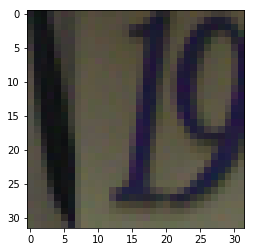

In [14]:
plt.imshow(X_train[0])
plt.show()

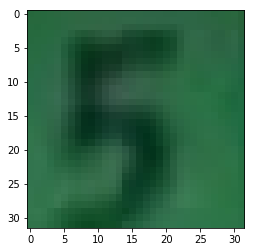

In [16]:
plt.imshow(X_test[0])
plt.show()

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
### Your code implementation goes here.
### Feel free to use as many code cells as needed.
seed = 7
np.random.seed(seed)
#using  Street View House Numbers (SVHN) data set (Not MNIST data)
X_train, y_train, X_test, y_test, input_shape, num_classes = load_digits_dataset (mnist_data=False)
# build the model
model = larger_model(input_shape, num_classes)
# Fit the model using 80% of training data and use remaining 20% for validation
n = round(.9*X_train.shape[0])
model.fit(X_train[:n], y_train[:n], validation_data=(X_train[n:], y_train[n:]), nb_epoch=5, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test  accuracy: %.2f%%" % (scores[1]*100))




Real Set      X Shape,       Y_shape
Training (32, 32, 3, 73257) (73257,)
Testing  (32, 32, 3, 26032) (26032,)

Final Data      X Shape,       Y_shape
Training (73257, 32, 32, 3) (73257, 10)
Testing  (26032, 32, 32, 3) (26032, 10)
input shape (32, 32, 3)
Train on 65931 samples, validate on 7326 samples
Epoch 1/5
369s - loss: 1.4318 - acc: 0.4345 - val_loss: 0.7113 - val_acc: 0.7189
Epoch 2/5
373s - loss: 0.6477 - acc: 0.7378 - val_loss: 0.4981 - val_acc: 0.7879
Epoch 3/5
372s - loss: 0.5174 - acc: 0.7780 - val_loss: 0.4258 - val_acc: 0.8084
Epoch 4/5
372s - loss: 0.4629 - acc: 0.7920 - val_loss: 0.3900 - val_acc: 0.8178
Epoch 5/5
370s - loss: 0.4265 - acc: 0.8014 - val_loss: 0.3672 - val_acc: 0.8225
Test  accuracy: 81.20%


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

I created load_digits_dataset() function to load either the MNIST or the SVHN datasets. The MNIST data was kept in the Theano style format while the SVHN was kept in TensorFlow style format.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
The NN model with tensor flow performed quite poorly. The introduction of additional layers made the model very sensitive as the gradient descent diverged resulting in NaN for loss. This could be helped by reducing the batch size and learning rate. However ther resulting accuracy was quite bad (in 20%). 

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
The CNN model using Keras performed quite well under the circumstances and with just 5 epochs reach accuracy of over 80%. The publication at Standford also confirms similar findings as they could also manage no more than 85% accuracy ever after 50 epochs.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
def larger_model(input_shape, num_classes):
	# create model
	model = Sequential()
	model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=input_shape, activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Convolution2D(16, 3, 3, activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(2048, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(512, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

### Your code implementation goes here.
### Feel free to use as many code cells as needed.



In [21]:
### Your code implementation goes here.
### Feel free to use as many code cells as needed.
seed = 7
np.random.seed(seed)
#using  Street View House Numbers (SVHN) data set (Not MNIST data)
X_train, y_train, X_test, y_test, input_shape, num_classes = load_digits_dataset (mnist_data=False)
# build the model
model = larger_model(input_shape, num_classes)
# Fit the model using 80% of training data and use remaining 20% for validation
n = round(.9*X_train.shape[0])
model.fit(X_train[:n], y_train[:n], validation_data=(X_train[n:], y_train[n:]), nb_epoch=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test  accuracy: %.2f%%" % (scores[1]*100))




Real Set      X Shape,       Y_shape
Training (32, 32, 3, 73257) (73257,)
Testing  (32, 32, 3, 26032) (26032,)

Final Data      X Shape,       Y_shape
Training (73257, 32, 32, 3) (73257, 10)
Testing  (26032, 32, 32, 3) (26032, 10)
input shape (32, 32, 3)
Train on 65931 samples, validate on 7326 samples
Epoch 1/10
393s - loss: 1.4318 - acc: 0.4345 - val_loss: 0.7113 - val_acc: 0.7189
Epoch 2/10
387s - loss: 0.6477 - acc: 0.7378 - val_loss: 0.4981 - val_acc: 0.7879
Epoch 3/10
388s - loss: 0.5174 - acc: 0.7780 - val_loss: 0.4258 - val_acc: 0.8084
Epoch 4/10
381s - loss: 0.4629 - acc: 0.7920 - val_loss: 0.3900 - val_acc: 0.8178
Epoch 5/10
385s - loss: 0.4265 - acc: 0.8014 - val_loss: 0.3672 - val_acc: 0.8225
Epoch 6/10
379s - loss: 0.3980 - acc: 0.8109 - val_loss: 0.3397 - val_acc: 0.8331
Epoch 7/10
374s - loss: 0.3787 - acc: 0.8166 - val_loss: 0.3444 - val_acc: 0.8295
Epoch 8/10
374s - loss: 0.3593 - acc: 0.8212 - val_loss: 0.3269 - val_acc: 0.8363
Epoch 9/10
383s - loss: 0.3469 - acc: 

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

In [22]:
import cv2
def get_image(imagefiles):
	nfile = len(imagefiles)
	img = np.zeros((nfile,32,32,3), dtype=np.float32)
	for i in range(nfile):
		img[i,] = cv2.imread(imagefiles[i])
	return img

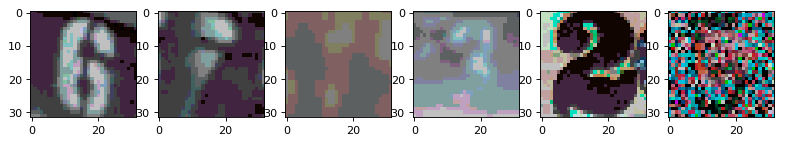

In [41]:
imagefiles =['digit1.bmp', 'digit2.bmp','digit3.bmp','digit4.bmp','digit5.bmp','digit6.bmp']
img = get_image(imagefiles)
fig = plt.figure(figsize=(12, 12), dpi=80)
for i in range(len(imagefiles)):
    plt.subplot(1,6,i+1)
    plt.imshow(img[i])
plt.show()

**Answer:**

I chose these images as they are from around my house and represent various fonts and some are really faded, e.g. third one. The last image is made with flowers in the garden.

In [32]:
y_pred = model.predict(img)
np.argmax(y_pred, 1)

array([6, 7, 7, 3, 2, 5], dtype=int64)

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**
As evident from the answer above, the model was able to predict all new six images correctly.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.